# 🏋️‍♀️Fitness identifier final version

<h2 style="font-size:20px; color:#3B82F6;">introductie</h2>

In dit notebook wordt een AI-model getraind dat fitnessoefeningen herkent op basis van beeldmateriaal. Dit project is uitgevoerd als persoonlijk project binnen de minor AI for Society, een minor waarin studenten kennismaken met kunstmatige intelligentie, leren over de mogelijkheden en risico’s van AI, en nadenken over hoe AI-toepassingen op een verantwoorde manier kunnen bijdragen aan de samenleving.

De keuze voor dit project komt voort uit mijn persoonlijke interesse in fitness en mijn eigen ervaringen in de sportschool. Het is mij opgevallen dat veel sporters, met name beginners, niet goed weten welke oefeningen zij uitvoeren, welke spiergroepen daarbij worden getraind en hoe een oefening technisch correct moet worden uitgevoerd. Dit kan leiden tot ineffectieve trainingen en een verhoogd risico op blessures.

Het uiteindelijke doel van dit project is om het getrainde AI-model te integreren in een mobiele applicatie die eenvoudig te gebruiken is tijdens het sporten. Met behulp van een timer maakt de gebruiker een foto van zichzelf met de voorcamera tijdens het uitvoeren van een oefening. Vervolgens herkent het AI-model welke oefening wordt uitgevoerd en toont de applicatie een resultatenpagina met relevante informatie, zoals de naam van de oefening, de getrainde spiergroepen en tips voor een optimale uitvoering. Op deze manier kan de applicatie sporters ondersteunen bij veilig en bewust trainen.



## 📑 Inhoudsopgave
- [1. Introductie](#1-introductie)
- [2. Dataset & Probleemdefinitie](#2-dataset--probleemdefinitie)
- [3. Train / Test Split](#3-train--test-split)
- [4. Model & Training](#4-model--training)
- [5. Testfase & Evaluatie](#5-testfase--evaluatie)
- [6. Inference & App](#6-inference--app)
- [7. Maatschappelijke Impact](#7-maatschappelijke-impact)
- [8. Conclusie](#8-conclusie)


-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

Sommige afbeeldingen in de dataset zijn niet volledig of bevatten kleine fouten. 
Door deze instelling toe te passen, kan het programma dergelijke afbeeldingen toch laden 
zonder dat het trainingsproces wordt onderbroken. Dit verhoogt de robuustheid van het project.


In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

We laden de benodigde libraries in en definiëren paden naar de trainingsdataset en een aparte map voor inference (demonstratie-afbeeldingen).
Daarnaast zetten we een vaste random seed, zodat de resultaten reproduceerbaar zijn: bij opnieuw uitvoeren van het notebook worden dezelfde willekeurige keuzes gemaakt.


In [7]:
import pandas, platform, os
import torch as T 
import torchvision as V
import pytorch_lightning as L
import torch.utils.data as D
import torchmetrics as M
import matplotlib.pyplot as plt

data_path = "dataset/data"
inference_path = "dataset/inference"

T.manual_seed(42)

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
T.manual_seed(seed)


print("Versions: python", platform.python_version(), "| torch", T.__version__, "| torchvision", V.__version__, "| pytorch_lightning", L.__version__)

Versions: python 3.14.0 | torch 2.9.1+cpu | torchvision 0.24.1+cpu | pytorch_lightning 2.5.6


In deze stap wordt gecontroleerd hoeveel afbeeldingen per fitnessoefening beschikbaar zijn.
Dit is belangrijk omdat een eerlijke evaluatie alleen mogelijk is wanneer elke oefening
voldoende voorbeelden bevat. Door te controleren dat elke klasse ongeveer evenveel afbeeldingen
heeft, kan later een gebalanceerde testset worden samengesteld waarin elke oefening even vaak wordt getest.


In [8]:
# === BLOK 2A — Check dataset folders ===
import os

data_path = "dataset/data"

# Veiligheid: check of pad bestaat
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Pad bestaat niet: {data_path}")

# Aantal foto's per map tellen
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.avif'))
        ])
        print(f"{folder}: {count} foto's")


cable_flyes: 75 foto's
incline_benchpress: 75 foto's
machine_pulldown: 75 foto's
pullup: 75 foto's
romanian_deadlift: 75 foto's
squats: 75 foto's


Voor dit project wordt gebruikgemaakt van een vooraf getraind ResNet-18 model.
Dit model is getraind op de ImageNet-dataset en heeft daardoor al geleerd om algemene
visuele kenmerken zoals randen, vormen en patronen te herkennen.
Door gebruik te maken van transfer learning kan met een relatief kleine dataset
toch een effectief model worden getraind, zonder dat het volledige netwerk vanaf nul hoeft te leren.

ResNet-18 is bewust gekozen vanwege de balans tussen modelcomplexiteit en rekentijd,
aangezien de focus van dit project ligt op betrouwbare evaluatie en niet op maximale modelgrootte.


In [9]:
pretrained_model = V.models.resnet18(weights="DEFAULT")

Alle afbeeldingen worden eerst geschaald naar een vast formaat voordat ze aan het model
worden aangeboden. Dit is noodzakelijk omdat neurale netwerken alleen met invoer van vaste
afmetingen kunnen werken. Voor dit project is gekozen voor een formaat dat aansluit bij
het ResNet-18 model.

De dataset wordt ingeladen met behulp van ImageFolder, waarbij elke map automatisch
wordt geïnterpreteerd als een aparte fitnessoefening. Hierdoor ontstaat een duidelijke
koppeling tussen afbeeldingen en labels.


In [10]:
image_size = (224, 224)

transform = V.transforms.Compose([
    V.transforms.Resize(image_size),
    V.transforms.ToTensor(),
])

dataset = V.datasets.ImageFolder(data_path, transform=transform)
classes = dataset.classes
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['cable_flyes', 'incline_benchpress', 'machine_pulldown', 'pullup', 'romanian_deadlift', 'squats']


In [11]:
from collections import Counter
print("ImageFolder counts:", {classes[k]: v for k, v in Counter(dataset.targets).items()})


ImageFolder counts: {'cable_flyes': 73, 'incline_benchpress': 74, 'machine_pulldown': 69, 'pullup': 71, 'romanian_deadlift': 73, 'squats': 70}


Om te controleren of de dataset correct is ingeladen, worden enkele willekeurige afbeeldingen
gevisualiseerd samen met hun labels. Deze stap dient als een visuele sanity check en helpt
bij het opsporen van mogelijke fouten in de dataset, zoals verkeerde labels of corrupte afbeeldingen.

Deze visualisatie is uitsluitend bedoeld ter controle van de data en vormt geen onderdeel
van de model-evaluatie.


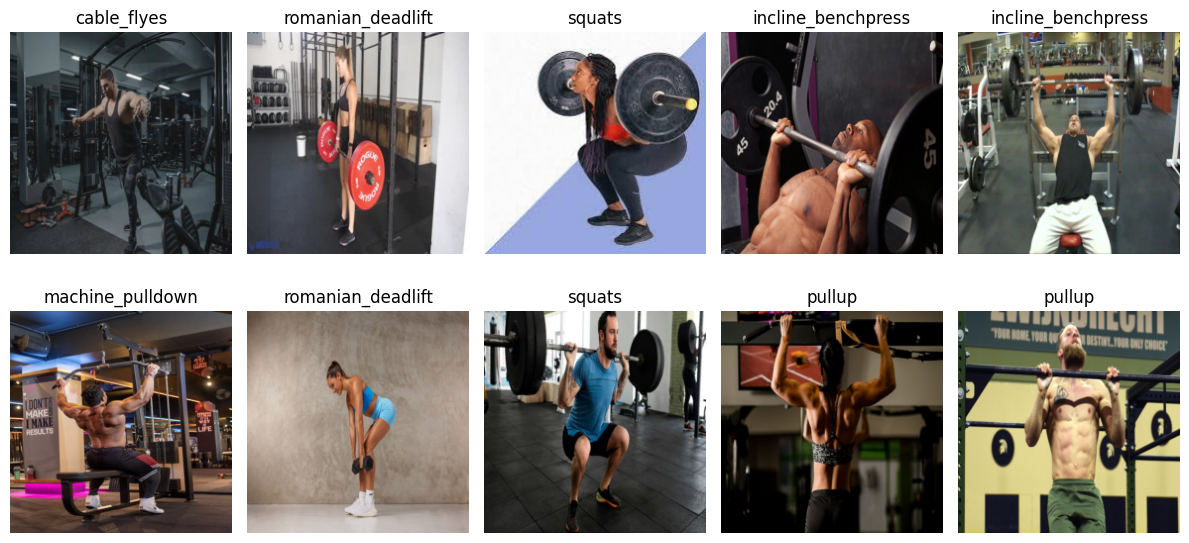

In [12]:
sample_size = 10
indices = T.randperm(len(dataset))[:sample_size]
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
fig, axes = plt.subplots(nrows=int(sample_size/5), ncols=5, figsize=(12, 6))
for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()

In [13]:
import torch as T
import torch.utils.data as D
from collections import defaultdict, Counter

def make_balanced_indices(dataset, test_per_class=10, val_per_class=10, seed=42):
    """
    Gebalanceerde split voor ImageFolder:
    - test: exact test_per_class per klasse
    - val:  exact val_per_class per klasse
    - train: de rest
    """
    g = T.Generator().manual_seed(seed)

    # ✅ Robuust: targets is aligned met dataset indices
    targets = dataset.targets
    num_classes = len(dataset.classes)

    per_class = defaultdict(list)
    for idx, y in enumerate(targets):
        per_class[y].append(idx)

    needed = test_per_class + val_per_class
    for c in range(num_classes):
        if len(per_class[c]) < needed:
            raise ValueError(
                f"Klasse '{dataset.classes[c]}' heeft {len(per_class[c])} samples. "
                f"Minimaal nodig: {needed}"
            )

    train_idx, val_idx, test_idx = [], [], []

    for c in range(num_classes):
        idxs = T.tensor(per_class[c])
        perm = idxs[T.randperm(len(idxs), generator=g)]

        test_idx += perm[:test_per_class].tolist()
        val_idx  += perm[test_per_class:test_per_class + val_per_class].tolist()
        train_idx += perm[test_per_class + val_per_class:].tolist()

    return train_idx, val_idx, test_idx


class DataModule(L.LightningDataModule):
    def __init__(self, data, batch_size=32, num_workers=0, test_per_class=10, val_per_class=10, seed=42):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.test_per_class = test_per_class
        self.val_per_class = val_per_class
        self.seed = seed

    def setup(self, stage=None):
        train_idx, val_idx, test_idx = make_balanced_indices(
            self.data,
            test_per_class=self.test_per_class,
            val_per_class=self.val_per_class,
            seed=self.seed
        )
        self.train = D.Subset(self.data, train_idx)
        self.val   = D.Subset(self.data, val_idx)
        self.test  = D.Subset(self.data, test_idx)

    def train_dataloader(self):
        return D.DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return D.DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return D.DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)


def subset_counts(subset, classes):
    # ✅ Robuust tellen via dataset.targets
    labels = [subset.dataset.targets[i] for i in subset.indices]
    c = Counter(labels)
    return {classes[i]: c.get(i, 0) for i in range(len(classes))}


# === Gebruik ===
datamodule = DataModule(dataset, batch_size=32, num_workers=0, test_per_class=10, val_per_class=10, seed=42)
datamodule.setup()

print("✅ Verdeling per split:")
print("Train:", subset_counts(datamodule.train, classes))
print("Val:  ", subset_counts(datamodule.val, classes))
print("Test: ", subset_counts(datamodule.test, classes))


✅ Verdeling per split:
Train: {'cable_flyes': 53, 'incline_benchpress': 54, 'machine_pulldown': 49, 'pullup': 51, 'romanian_deadlift': 53, 'squats': 50}
Val:   {'cable_flyes': 10, 'incline_benchpress': 10, 'machine_pulldown': 10, 'pullup': 10, 'romanian_deadlift': 10, 'squats': 10}
Test:  {'cable_flyes': 10, 'incline_benchpress': 10, 'machine_pulldown': 10, 'pullup': 10, 'romanian_deadlift': 10, 'squats': 10}


In [14]:
import torch as T
import torchmetrics as M

class ImageClassifierModel(L.LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True, class_names=None):
        super().__init__()
        self.num_classes = num_classes
        self.class_names = class_names  # lijst met classnamen (optioneel maar handig)
        
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters():
                param.requires_grad = False
        
        # vervang classifier head
        self.model.fc = T.nn.Linear(self.model.fc.in_features, num_classes)

        self.criterion = T.nn.CrossEntropyLoss()

        # per-class metrics (average="none")
        self.accuracy = M.Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = M.Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = M.Recall(task="multiclass", num_classes=self.num_classes, average="none")

        # buffers voor confusion matrix & foutenanalyse
        self.test_true = []
        self.test_pred = []
        self.test_conf = []  # confidence van voorspelde klasse

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return T.optim.Adam(self.parameters(), lr=0.002)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        val_loss = self.criterion(logits, y)
        self.log("val_loss", val_loss, prog_bar=True)

    def on_test_epoch_start(self):
        # reset metrics + buffers
        self.accuracy.reset()
        self.precision.reset()
        self.recall.reset()
        self.test_true = []
        self.test_pred = []
        self.test_conf = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        probs = T.softmax(logits, dim=1)
        preds = T.argmax(probs, dim=1)
        confs = probs[T.arange(probs.size(0)), preds]  # confidence van gekozen klasse

        # update metrics
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)

        # sla op voor confusion matrix & foutenanalyse
        self.test_true.append(y.detach().cpu())
        self.test_pred.append(preds.detach().cpu())
        self.test_conf.append(confs.detach().cpu())

    def on_test_epoch_end(self):
        # compute per-class metrics
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()

        # support = aantal testvoorbeelden per klasse
        y_true = T.cat(self.test_true)
        support = T.bincount(y_true, minlength=self.num_classes)

        # log per klasse (met classnaam als die bestaat)
        for i in range(self.num_classes):
            name = self.class_names[i] if self.class_names else str(i)

            self.log(f"test_accuracy_{name}", accuracy[i])
            self.log(f"test_precision_{name}", precision[i])
            self.log(f"test_recall_{name}", recall[i])
            self.log(f"test_support_{name}", support[i].float())

        # (optioneel) log macro gemiddelden
        self.log("test_accuracy_macro", accuracy.mean())
        self.log("test_precision_macro", precision.mean())
        self.log("test_recall_macro", recall.mean())


In [15]:
model = ImageClassifierModel(pretrained_model, num_classes=len(classes), freeze_layers=True, class_names=classes)

In [16]:
logger = L.loggers.CSVLogger(save_dir="logs", name="fitness_identifier")

early_stop = L.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=True
)

trainer = L.Trainer(
    max_epochs=-1,
    logger=logger,
    callbacks=[early_stop],
    deterministic=True
)

trainer.fit(model, datamodule=datamodule)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
3.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\yusuf\AppData\Roaming\Python\Python314\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


C:\Users\yusuf\AppData\Roaming\Python\Python314\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\yusuf\AppData\Roaming\Python\Python314\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 10/10 [00:19<00:00,  0.50it/s, v_num=4, train_loss=2.100, val_loss=1.890]

Metric val_loss improved. New best score: 1.886


Epoch 1: 100%|██████████| 10/10 [00:15<00:00,  0.66it/s, v_num=4, train_loss=1.430, val_loss=1.680]

Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 1.685


Epoch 2: 100%|██████████| 10/10 [00:15<00:00,  0.66it/s, v_num=4, train_loss=1.320, val_loss=1.410]

Metric val_loss improved by 0.277 >= min_delta = 0.0. New best score: 1.407


Epoch 3: 100%|██████████| 10/10 [00:15<00:00,  0.66it/s, v_num=4, train_loss=1.030, val_loss=1.300]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 1.303


Epoch 4: 100%|██████████| 10/10 [00:14<00:00,  0.67it/s, v_num=4, train_loss=0.937, val_loss=1.200]

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.195


Epoch 5: 100%|██████████| 10/10 [00:14<00:00,  0.68it/s, v_num=4, train_loss=0.926, val_loss=1.150]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.146


Epoch 6: 100%|██████████| 10/10 [00:14<00:00,  0.68it/s, v_num=4, train_loss=0.805, val_loss=1.100]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.102


Epoch 7: 100%|██████████| 10/10 [00:14<00:00,  0.69it/s, v_num=4, train_loss=0.769, val_loss=1.090]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.088


Epoch 8: 100%|██████████| 10/10 [00:15<00:00,  0.65it/s, v_num=4, train_loss=0.771, val_loss=1.070]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.073


Epoch 9: 100%|██████████| 10/10 [00:15<00:00,  0.65it/s, v_num=4, train_loss=0.462, val_loss=1.030]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.033


Epoch 10: 100%|██████████| 10/10 [00:15<00:00,  0.66it/s, v_num=4, train_loss=0.683, val_loss=1.010]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.008


Epoch 11: 100%|██████████| 10/10 [00:15<00:00,  0.63it/s, v_num=4, train_loss=0.586, val_loss=1.010]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.005


Epoch 12: 100%|██████████| 10/10 [00:15<00:00,  0.64it/s, v_num=4, train_loss=0.464, val_loss=0.984]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.984


Epoch 14: 100%|██████████| 10/10 [00:15<00:00,  0.66it/s, v_num=4, train_loss=0.543, val_loss=0.971]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.971


Epoch 17: 100%|██████████| 10/10 [00:16<00:00,  0.59it/s, v_num=4, train_loss=0.497, val_loss=0.957]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.957


Epoch 19: 100%|██████████| 10/10 [00:19<00:00,  0.52it/s, v_num=4, train_loss=0.486, val_loss=0.949]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.949


Epoch 20: 100%|██████████| 10/10 [00:19<00:00,  0.51it/s, v_num=4, train_loss=0.378, val_loss=0.946]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.946


Epoch 23: 100%|██████████| 10/10 [00:16<00:00,  0.59it/s, v_num=4, train_loss=0.371, val_loss=0.938]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.938


Epoch 25: 100%|██████████| 10/10 [00:17<00:00,  0.57it/s, v_num=4, train_loss=0.365, val_loss=0.936]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.936


Epoch 30: 100%|██████████| 10/10 [00:17<00:00,  0.56it/s, v_num=4, train_loss=0.301, val_loss=0.948]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.936. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 10/10 [00:18<00:00,  0.55it/s, v_num=4, train_loss=0.301, val_loss=0.948]


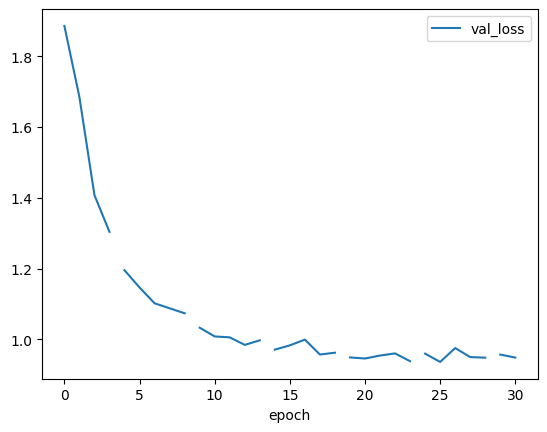

In [17]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [18]:
# 1. Test uitvoeren
scores = trainer.test(model, datamodule=datamodule, verbose=False)

# 2. Per-klasse metrics ophalen
accuracies = [scores[0][f"test_accuracy_{cls}"] for cls in classes]
precisions = [scores[0][f"test_precision_{cls}"] for cls in classes]
recalls = [scores[0][f"test_recall_{cls}"] for cls in classes]
supports = [scores[0][f"test_support_{cls}"] for cls in classes]

# 3. Overzichtstabel maken
df = pandas.DataFrame({
    "class": classes,
    "accuracy": accuracies,
    "precision": precisions,
    "recall": recalls,
    "support": supports
}).set_index("class")

df


C:\Users\yusuf\AppData\Roaming\Python\Python314\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.92it/s]


,accuracy,precision,recall,support
class,,,,
cable_flyes,0.9,0.692308,0.9,10.0
incline_benchpress,0.6,0.750000,0.6,10.0
machine_pulldown,0.7,0.777778,0.7,10.0
pullup,0.8,0.888889,0.8,10.0
romanian_deadlift,0.8,0.727273,0.8,10.0
squats,0.4,0.400000,0.4,10.0


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Verzamel true en predicted labels uit het model
y_true = torch.cat(model.test_true).numpy()
y_pred = torch.cat(model.test_pred).numpy()

# Confusion matrix (genormaliseerd per rij)
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=range(len(classes)),
    # normalize="true"
)

cm


array([[9, 1, 0, 0, 0, 0],
       [2, 6, 0, 0, 0, 2],
       [0, 1, 7, 1, 0, 1],
       [0, 0, 1, 8, 0, 1],
       [0, 0, 0, 0, 8, 2],
       [2, 0, 1, 0, 3, 4]])

<Axes: >

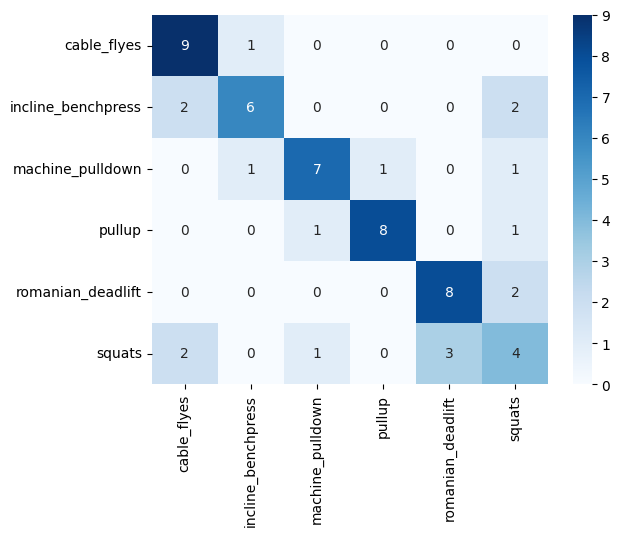

In [20]:
import seaborn 

seaborn.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues")

Cable flyes worden bijna altijd goed herkend → duidelijke houding

Pull-ups en machine pulldowns worden soms verwisseld → lijken visueel op elkaar

Squats worden vaak verward met romanian deadlift → vergelijkbare lichaamshouding

Dit verklaart waarom sommige oefeningen lagere accuracy hebben

<h2 style="font-size:20px; color:#3B82F6;">Waarom random split in het begin oké is</h2>
In de eerste fase wil je snel controleren of je idee werkt. Een random split is dan handig: je krijgt snel een train/val/test set zonder veel extra werk.

<h2 style="font-size:20px; color:#3B82F6;">Waarom het voor beoordeling niet meer genoeg is</h2>
Bij een random split kan het gebeuren dat sommige oefeningen veel vaker in de testset zitten dan andere. Dan lijkt het model soms “heel goed” op een oefening, terwijl die oefening misschien maar 1 of 2 keer getest is. Dat is niet eerlijk vergelijken.

<h2 style="font-size:20px; color:#3B82F6;">Wat een gebalanceerde testset betekent</h2>
Een gebalanceerde testset betekent dat elke oefening exact evenveel testfoto’s heeft (bijvoorbeeld 10 per oefening). Daardoor kun je resultaten eerlijk vergelijken en zijn je metrics (accuracy/precision/recall) betrouwbaar.

# model klaarmaken voor export om te gerbuiken in app

In [21]:
import torch as T
import torchvision as V

T.save(model.state_dict(), "model.pth")


Omdat ik de nieuwste vesie van python gebruik en de libraries nog achterlopen qua updates, heb ik in een aparte project de model.pth file die ik hier boven heb aangemaakt, omgezet naar een .tflite bestand. Hierdoor kan ik het AI-model gebruiken in mijn app

# Data uit de grafieken omzetten naar JSON zodat de data gebruikt kan worden om grafieken te maken binnen de app

In [ ]:
import json
import os

# === 1. LOSS CURVE UIT METRICS.CSV ===
val_loss_values = metrics["val_loss"].dropna().tolist()
val_loss_values = [round(float(x), 5) for x in val_loss_values]

# Helper: probeer meerdere mogelijke keys zonder te crashen
def get_score(scores0, keys):
    for k in keys:
        if k in scores0:
            return scores0[k]
    raise KeyError(f"Geen van deze keys gevonden in scores[0]: {keys}")

scores0 = scores[0]  # jouw test result dict

# === 2. PER-CLASS METRICS (accuracy blijft exact zoals je had) ===
accuracy = {}
precision = {}
recall = {}
support = {}

for i, class_name in enumerate(classes):
    # 2a) Accuracy (houd jouw huidige format aan)
    acc = get_score(scores0, [
        f"test_accuracy_class_{i}",        # jouw huidige export
        f"test_accuracy_{class_name}",     # jouw eerdere cell (op naam)
    ])
    accuracy[class_name] = round(float(acc), 2)

    # 2b) Precision
    prec = get_score(scores0, [
        f"test_precision_class_{i}",
        f"test_precision_{class_name}",
    ])
    precision[class_name] = round(float(prec), 2)

    # 2c) Recall
    rec = get_score(scores0, [
        f"test_recall_class_{i}",
        f"test_recall_{class_name}",
    ])
    recall[class_name] = round(float(rec), 2)

    # 2d) Support (liefst int, want het is een count)
    sup = get_score(scores0, [
        f"test_support_class_{i}",
        f"test_support_{class_name}",
    ])
    support[class_name] = int(round(float(sup), 0))

# === 3. DATASET DISTRIBUTION ===
dataset_distribution = {}
for class_name in classes:
    folder_path = os.path.join(data_path, class_name)
    dataset_distribution[class_name] = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.avif'))
    ])

# === 4. BOUW HET JSON OBJECT (breekt niks: accuracy blijft bestaan) ===
stats = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "support": support,
    "loss_curve": val_loss_values,
    "dataset_distribution": dataset_distribution
}

# === 4. CONFUSION MATRIX ===

# cm is een numpy array shape (C, C)
stats["confusion_matrix"] = {
    "labels": classes,          # volgorde van classes
    "matrix": cm.tolist(),      # 2D list voor JSON
}


# === 5. OPSLAAN ===
with open("model_stats.json", "w") as f:
    json.dump(stats, f, indent=4)

print("model_stats.json succesvol aangemaakt (uitgebreid met precision/recall/support)!")

model_stats.json succesvol aangemaakt (uitgebreid met precision/recall/support)!
